#Detection of Covid Positive Cases using Radiography Data

### Introduction

To explore X-ray images as doctors frequently use X-rays and CT scans to diagnose pneumonia, lung inflammation, abscesses, and/or enlarged lymph nodes.

Since COVID-19 attacks the epithelial cells that line our respiratory tract, we can use X-rays to analyze the health of a patient’s lungs.

### Loading Required Libraries 

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Reading 

import os
from glob import glob
from PIL import Image

# Data Processing 

import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A

# Data Analysis

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Data Modeling & Model Evaluation

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

# Grad-CAM

import keras
import matplotlib.cm as cm

### Reading The Data

In [4]:
from zipfile import ZipFile
with ZipFile('COVID-19_Radiography_Dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [5]:
levels = ['Normal/images', 'COVID/images']
path = "COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal/images': 'Negative', 'COVID/images': 'Positive'})
samples = 13808

data.head()

,image_file,corona_result,path
0,Normal/images/Normal-6338.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
1,Normal/images/Normal-5535.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
2,Normal/images/Normal-4373.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
3,Normal/images/Normal-9641.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
4,Normal/images/Normal-568.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...


In [6]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 13808


## Exploratory Data Analysis 

### 1. Count Plot 

In [7]:
df = pd.DataFrame()
df['corona_result'] = ['Positive', 'Negative']
df['Count'] = [len(data[data['corona_result'] == 'Positive']), len(data[data['corona_result'] == 'Negative'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'corona_result', y = 'Count', 
             color = "corona_result", text_auto='', width = 600, 
             color_discrete_sequence = ["orange", "purple"],
             template = 'plotly_dark')

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

### 2. Image Samples

In [8]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))
data.head()

,image_file,corona_result,path,image
0,Normal/images/Normal-6338.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."
1,Normal/images/Normal-5535.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[139, 56, 24, 20, 21, 21, 20, 20, 20, 21, 21,..."
2,Normal/images/Normal-4373.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[20, 22, 24, 25, 26, 26, 27, 28, 27, 26, 22, ..."
3,Normal/images/Normal-9641.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[13, 7, 7, 8, 9, 9, 9, 9, 9, 9, 9, 9, 11, 11,..."
4,Normal/images/Normal-568.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[0, 0, 5, 27, 48, 70, 82, 94, 102, 101, 97, 9..."


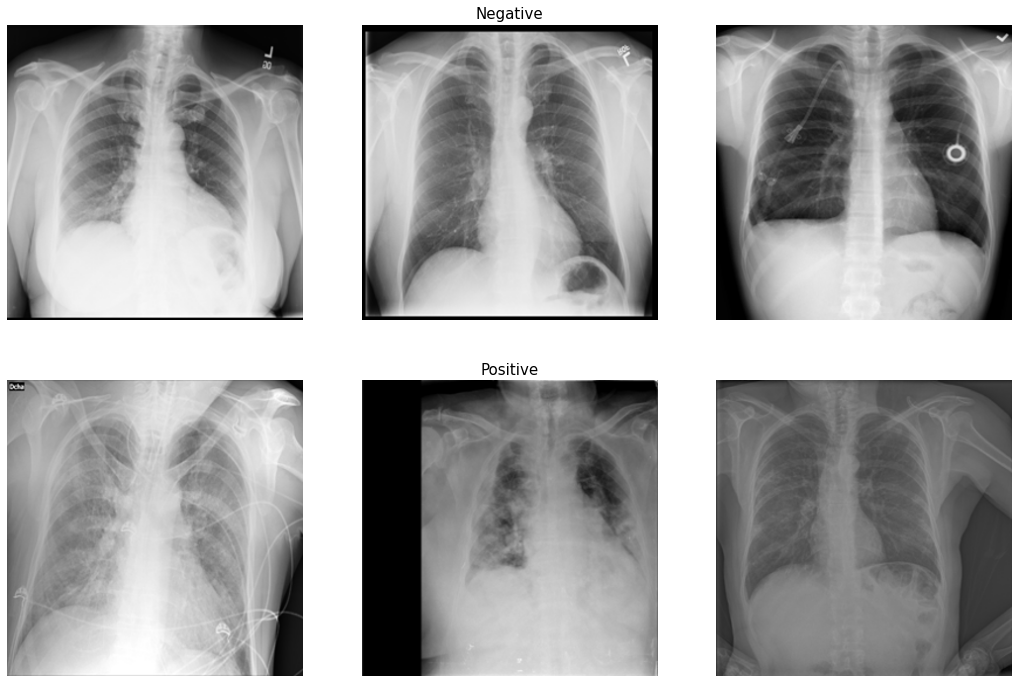

In [9]:
n_samples = 3

fig, m_axs = plt.subplots(2, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['corona_result']).groupby('corona_result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

### 3. Random Image Analysis

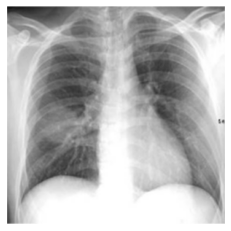

In [10]:
plt.figure()
image = cv2.imread("../content/COVID-19_Radiography_Dataset/COVID/images/COVID-1002.png")
plt.imshow(image)
plt.axis('off')
plt.show() 

In [11]:
print('Image Shape: {}'.format(image.shape))
print('Image Height: {}'.format(image.shape[0]))
print('Image Width: {}'.format(image.shape[1]))
print('Image Dimension: {}'.format(image.ndim))
print('Image Size: {}kb'.format(image.size//1024))
print('Image Data Type: {}'.format(image.dtype))
print('Maximum RGB value of the image: {}'.format(image.max()))
print('Minimum RGB value of the image: {}'.format(image.min()))

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261kb
Image Data Type: uint8
Maximum RGB value of the image: 255
Minimum RGB value of the image: 5


### 4. B-Channel

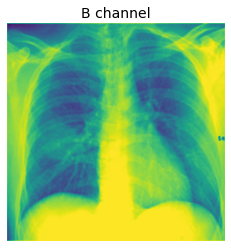

In [12]:
plt.title('B channel', fontsize = 14)
plt.imshow(image[ : , : , 0])
plt.axis('off');
plt.show()

### 5. Ben Graham's Method

In [13]:
all_covid = []
all_normal = []

all_normal.extend(glob(os.path.join(path, "Normal/images/*.png")))
all_covid.extend(glob(os.path.join(path, "COVID/images/*.png")))

random.shuffle(all_normal)
random.shuffle(all_covid)

images = all_normal[:50] + all_covid[:50]

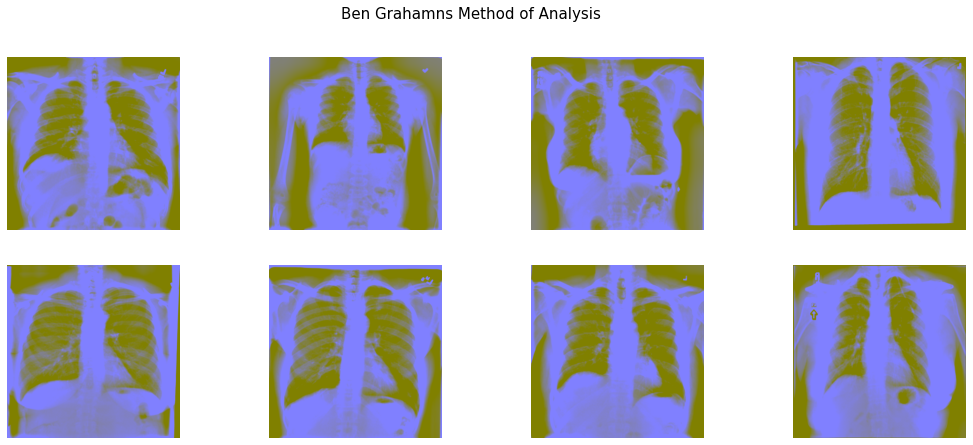

In [14]:
fig = plt.figure(figsize = (18, 7))
fig.suptitle("Ben Grahamns Method of Analysis", fontsize = 15)
columns = 4; rows = 2

for i in range(1, columns*rows+1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

### 6. Albumentations Visualization

In [15]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()

In [16]:
chosen_image = cv2.imread(".COVID-19_Radiography_Dataset/COVID/images/COVID-1002.png")

albumentation_list = [A.RandomFog(p = 1), A.RandomBrightness(p = 1),
                      A.RandomCrop(p = 1,height = 199, width = 199), A.Rotate(p = 1, limit = 90),
                      A.RGBShift(p = 1), A.VerticalFlip(p = 1), A.RandomContrast(limit = 0.5, p = 1)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original", "RandomFog", "RandomBrightness", "RandomCrop", "Rotate", "RGBShift", "VerticalFlip", "RandomContrast"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4, main_title = "Different Types of Augmentations")

AttributeError: ignored

### 7. Image Value Distribution

In [17]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0, samples):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image','corona_result','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

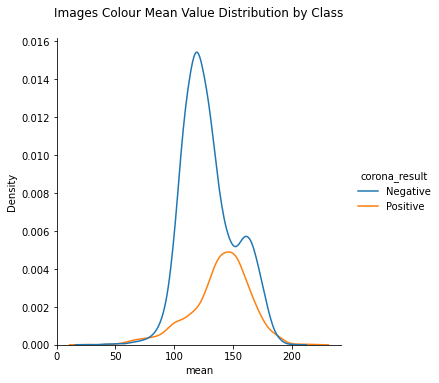

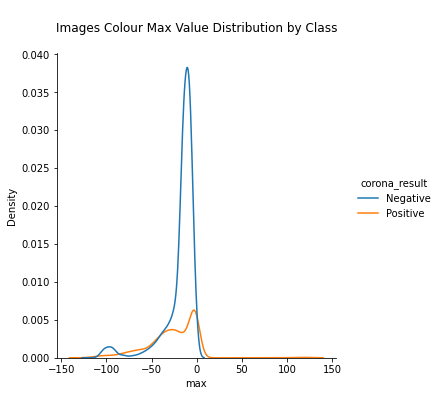

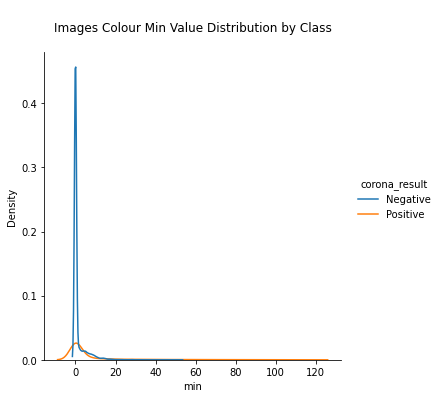

In [18]:
ax1 = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'corona_result');
plt.title('Images Colour Mean Value Distribution by Class\n', fontsize = 12);

ax2 = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'corona_result');
plt.title('\nImages Colour Max Value Distribution by Class\n', fontsize = 12);

ax3 = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'corona_result');
plt.title('\nImages Colour Min Value Distribution by Class\n', fontsize = 12);

> The Mean vs Density plot insights for pixels:
> 1. The max pixel value for Covid Negative cases is greater than 0.014 and less than 0.016.
> 2. The max pixel value for Covid Positive cases is greater than 0.004 & less than 0.006.

> The Max vs Density plot insights for pixels:
> 1. The max pixel value for Covid Negative cases is greater than 0.035 and less than 0.040.
> 2. The max pixel value for Covid Positive cases is 0.005.

> The Min vs Density plot insights for pixels:
> 1. The max pixel value for Covid Negative cases is greater than 0.4.
> 2. The max pixel value for Covid Positive cases is greater than 0.0 and less than 0.1.

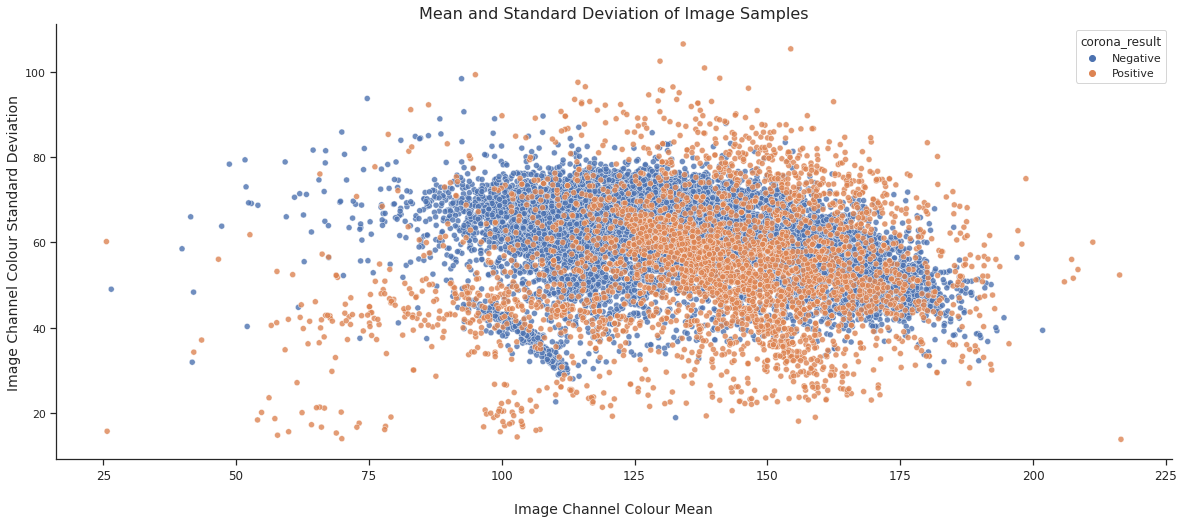

In [19]:
plt.figure(figsize = (20, 8))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA, x = "mean", y = imageEDA['stedev'], hue = 'corona_result', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nImage Channel Colour Mean', fontsize = 14)
ax.set_ylabel('Image Channel Colour Standard Deviation', fontsize = 14)
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16);

> We observe that there are 2 clusters formed, one for Covid Positive, one for Covid Negative and both have several overlappings. Overlapping Color Mean range: (100 - 175)

> We observe that for pixels having Std Deviation below 30 are all Covid Positive Images (Orange Colored).

<Figure size 720x576 with 0 Axes>

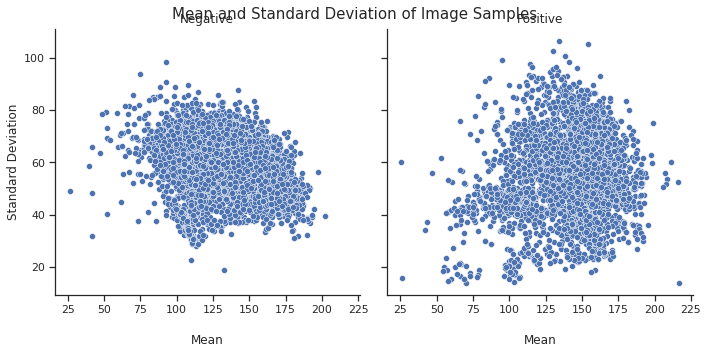

In [20]:
plt.figure(figsize = (10, 8));
g = sns.FacetGrid(imageEDA, col = "corona_result", height = 5);
g.map_dataframe(sns.scatterplot, x = 'mean', y = 'stedev');
g.set_titles(col_template = "{col_name}", row_template= "{row_name}", size = 12);
g.fig.subplots_adjust(top = .7);
g.fig.suptitle('Mean and Standard Deviation of Image Samples', fontsize = 15);
axes = g.axes.flatten();
axes[0].set_ylabel('Standard Deviation');
for ax in axes:
    ax.set_xlabel('\nMean');
g.fig.tight_layout();

## Data Modeling 

### Train Test Split 

In [21]:
all_data = []

# Storing images and their labels into a list for further Train Test split

for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (70, 70)) / 255.0
    label = 1 if data['corona_result'][i] == "Positive" else 0
    all_data.append([image, label])

In [22]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(9941, 70, 70, 3) (2762, 70, 70, 3) (1105, 70, 70, 3) (9941,) (2762,) (1105,)


### CNN Model

In [23]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
cnn_model.add(layers.Dropout(0.2))

cnn_model.add(layers.Dense(units = 2))

cnn_model.compile(optimizer = 'adam', 
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
           metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 34, 34, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [24]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

#tf.random.set_seed(42)
history = cnn_model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [es])

Epoch 1/50
39/39 [==============================] - 18s 151ms/step - loss: 0.5633 - accuracy: 0.7235 - val_loss: 0.4857 - val_accuracy: 0.7638
Epoch 2/50
39/39 [==============================] - 4s 98ms/step - loss: 0.4805 - accuracy: 0.7330 - val_loss: 0.4273 - val_accuracy: 0.7638
Epoch 3/50
39/39 [==============================] - 4s 99ms/step - loss: 0.4377 - accuracy: 0.7838 - val_loss: 0.3630 - val_accuracy: 0.8172
Epoch 4/50
39/39 [==============================] - 4s 99ms/step - loss: 0.3937 - accuracy: 0.8247 - val_loss: 0.3276 - val_accuracy: 0.8805
Epoch 5/50
39/39 [==============================] - 4s 99ms/step - loss: 0.3610 - accuracy: 0.8513 - val_loss: 0.3029 - val_accuracy: 0.8688
Epoch 6/50
39/39 [==============================] - 4s 100ms/step - loss: 0.3374 - accuracy: 0.8656 - val_loss: 0.2731 - val_accuracy: 0.8923
Epoch 7/50
39/39 [==============================] - 4s 99ms/step - loss: 0.3122 - accuracy: 0.8815 - val_loss: 0.2656 - val_accuracy: 0.9086
Epoch 8/50

In [25]:
yp_train = cnn_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = cnn_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = cnn_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

### Model Evaluation

In [26]:
def evaluation_parametrics(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: ", round(recall_score(y_train, yp_train),4))
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train),4))
    print("Precision on Train Data: ", round(precision_score(y_train, yp_train),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")
       
    cm_val = confusion_matrix(y_val, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")
    print("Recall on Val Data: ", round(recall_score(y_val, yp_val),4))
    print("Specificity on Val Data: ", s2)
    print("Accuracy on Val Data: ", round(accuracy_score(y_val, yp_val),4))
    print("Precision on Val Data: ", round(precision_score(y_val, yp_val),4))
    print("F1 Score on Val Data: ", round(f1_score(y_val, yp_val),4))
    print("--------------------------------------------------------------------------")

    cm_test = confusion_matrix(y_test, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test, yp_test), 4))
    print("Specificity on Test Data: ", s3)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()   
    t3.plot()


-----------------------------Convolution Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7287
           1       0.99      0.99      0.99      2654

    accuracy                           0.99      9941
   macro avg       0.99      0.99      0.99      9941
weighted avg       0.99      0.99      0.99      9941

--------------------------------------------------------------------------
Recall on Train Data:  0.9936
Specificity on Train Data:  0.9952
Accuracy on Train Data:  0.9948
Precision on Train Data:  0.9869
F1 Score on Train Data:  0.9902
--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       844
           1       0.92      0.94      0.93       261

    accuracy                

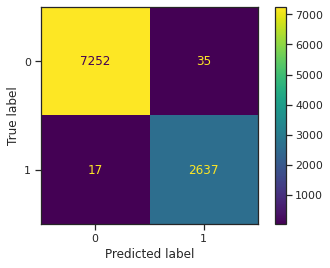

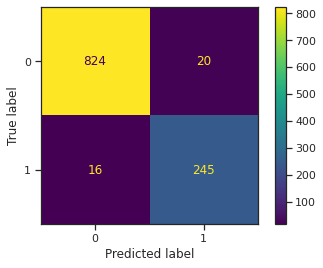

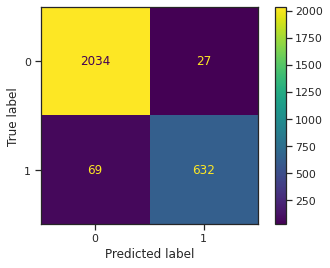

In [27]:
evaluation_parametrics("Convolution Neural Network", y_train, yp_train, y_val, yp_val, y_test, yp_test)

In [28]:
# list all data in history

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


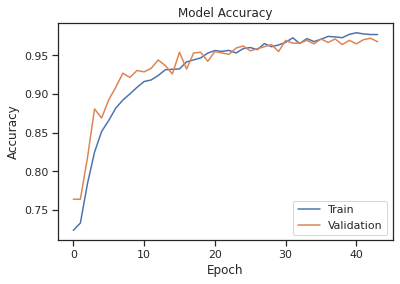

In [29]:
# Summarize History for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

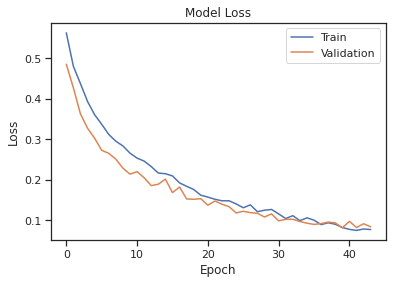

In [30]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

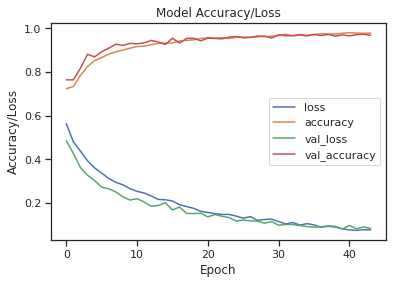

In [31]:
# Accuracy Loss Graph

pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

> We observe that Train & Validation Accuracy's Curve slightly overlap and same with Loss Curve. 

> Hence, Overfitting is avoided, this is possible because of Dropout Regularization & Early Stopping Metrics.

# Image Analysis using Grad-CAM 

### Config- Parameters

In [35]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

last_conv_layer_name = "block14_sepconv2_act"

# Reading 2 Covid & 2 Normal Images for Grad-Cam Analysis

img_path = ["COVID-19_Radiography_Dataset/COVID/images/COVID-1002.png",
            "COVID-19_Radiography_Dataset/COVID/images/COVID-101.png",
            "COVID-19_Radiography_Dataset/Normal/images/Normal-10004.png",
           "COVID-19_Radiography_Dataset/Normal/images/Normal-10002.png"]

### Grad - CAM Algorithm

In [36]:
# To Get Image into numpy array

def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size = size) 
    array = keras.preprocessing.image.img_to_array(img) 
    array = np.expand_dims(array, axis = 0)
    return array

# Top create heatmaps for the samples

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

### Heatmap 

In [37]:
# Storing Heatmap values into list

covid_noncovid_heatmap = []

for i in img_path:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model_builder(weights = "imagenet")
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    covid_noncovid_heatmap.append(heatmap)

91897856/91884032 [==============================] - 2s 0us/step


### Creating a Superimposed Viz

In [38]:
# To Display GradCAM output for the samples

def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    
    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))


for i in range(len(img_path)):
    save_and_display_gradcam(img_path[i], covid_noncovid_heatmap[i])

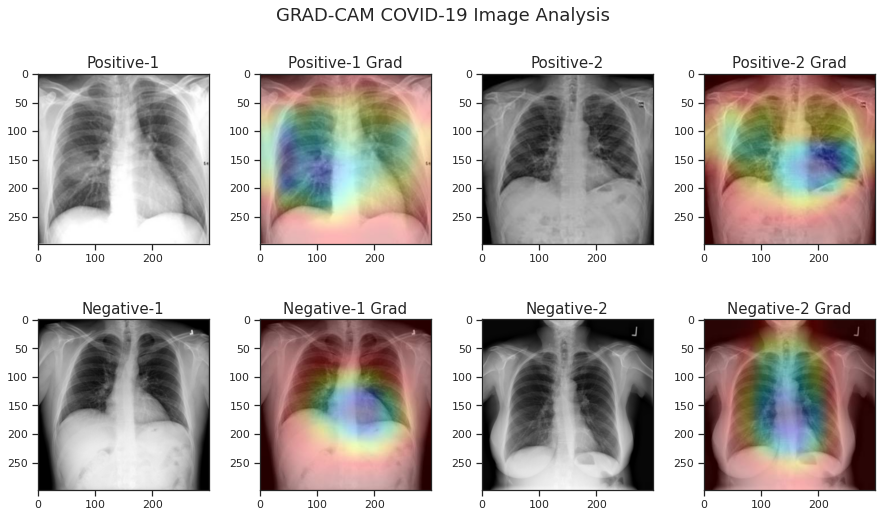

In [39]:
titles_list = ["Positive-1",'Positive-1 Grad','Positive-2','Positive-2 Grad','Negative-1','Negative-1 Grad','Negative-2','Negative-2 Grad']

plot_multiple_img(imag, titles_list, ncols = 4, main_title = "GRAD-CAM COVID-19 Image Analysis")

> Positive-1 Sample Insight: In its Grad-CAM image on the right mid part of it we can see the blue color highlighted portion which is opacity due to which it belongs to COVID - Positive Category.

> Positive-2 Sample Insight: In its Grad-CAM image on the left bottom part of it we can see the blue green color highlighted portion which is consolidation and no Tree-Bud due to which it belongs to COVID - Positive Category.

> Negative-1 Sample Insight: In its Grad-CAM image we can see the blue color highlighted portion which is between the Cardiac and Diaphragm and no any opacity was detected due to which it belongs to COVID - Negative Category.

> Negative-2 Sample Insight: In its Grad-CAM image we can see the blue color portion which highlights the Trachea and no other opacity was detected due to which it belongs to COVID - Negative Category.

### Checking with Model

In [40]:
# Checking predictions for the above sample images

for i in img_path:
    z_img = cv2.imread(i)
    z_img = cv2.resize(z_img, (70, 70)) / 255.0
    z_img = z_img.reshape(1, z_img.shape[0], z_img.shape[1], z_img.shape[2])
    
    z = cnn_model.predict(z_img)
    z = np.argmax(z, axis = 1)
    print("Image", img_path.index(i) + 1, ":", z)

Image 1 : [1]
Image 2 : [1]
Image 3 : [0]
Image 4 : [0]


# Saving Model

In [41]:
cnn_model.save('cnn_model.h5')